# Predicting the Stock Market 

In this project, you'll be working with data from the S&P500 Index. The S&P500 is a stock market index. Before we get into what an index is, we'll need to get into the basics of the stock market.

Some companies are publicly traded, which means that anyone can buy and sell their shares on the open market. A share entitles the owner to some control over the direction of the company, and to some percentage (or share) of the earnings of the company. When you buy or sell shares, it's common to say that you're trading a stock.

The price of a share is based mainly on supply and demand for a given stock. For example, Apple stock has a price of 120 dollars per share as of December 2015 -- http://www.nasdaq.com/symbol/aapl. A stock that is in less demand, like Ford Motor Company, has a lower price -- http://finance.yahoo.com/q?s=F. Stock price is also influenced by other factors, including the number of shares a company has issued.

Stocks are traded daily, and the price can rise or fall from the beginning of a trading day to the end based on demand. Stocks that are in more in demand, such as Apple, are traded more often than stocks of smaller companies.

Indexes aggregate the prices of multiple stocks together, and allow you to see how the market as a whole is performing. For example, the Dow Jones Industrial Average aggregates the stock prices of 30 large American companies together. The S&P500 Index aggregates the stock prices of 500 large companies. When an index fund goes up or down, you can say that the underlying market or sector it represents is also going up or down. For example, if the Dow Jones Industrial Average price goes down one day, you can say that American stocks overall went down (ie, most American stocks went down in price).

You'll be using historical data on the price of the S&P500 Index to make predictions about future prices. Predicting whether an index will go up or down will help us forecast how the stock market as a whole will perform. Since stocks tend to correlate with how well the economy as a whole is performing, it can also help us make economic forecasts.

There are also thousands of traders who make money by buying and selling Exchange Traded Funds. ETFs allow you to buy and sell indexes like stocks. This means that you could "buy" the S&P500 Index ETF when the price is low, and sell when it's high to make a profit. Creating a predictive model could allow traders to make money on the stock market.

In this mission, you'll be working with a csv file containing index prices. Each row in the file contains a daily record of the price of the S&P500 Index from 1950 to 2015. The dataset is stored in sphist.csv.

The columns of the dataset are:

- Date -- The date of the record.
- Open -- The opening price of the day (when trading starts).
- High -- The highest trade price during the day.
- Low -- The lowest trade price during the day.
- Close -- The closing price for the day (when trading is finished).
- Volume -- The number of shares traded.
Adj Close -- The daily closing price, adjusted retroactively to include any corporate actions. Read more here.
You'll be using this dataset to develop a predictive model. You'll train the model with data from 1950-2012, and try to make predictions from 2013-2015.



In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [172]:
sphist = pd.read_csv('sphist.csv', parse_dates = ['Date'])
sphist.sort_values(by='Date', inplace = True)
sphist = sphist.set_index('Date')

Let us take a glimpse on the data and how it looks like. As we can see this is a times series of the closing price for each day from 1950 to 2015

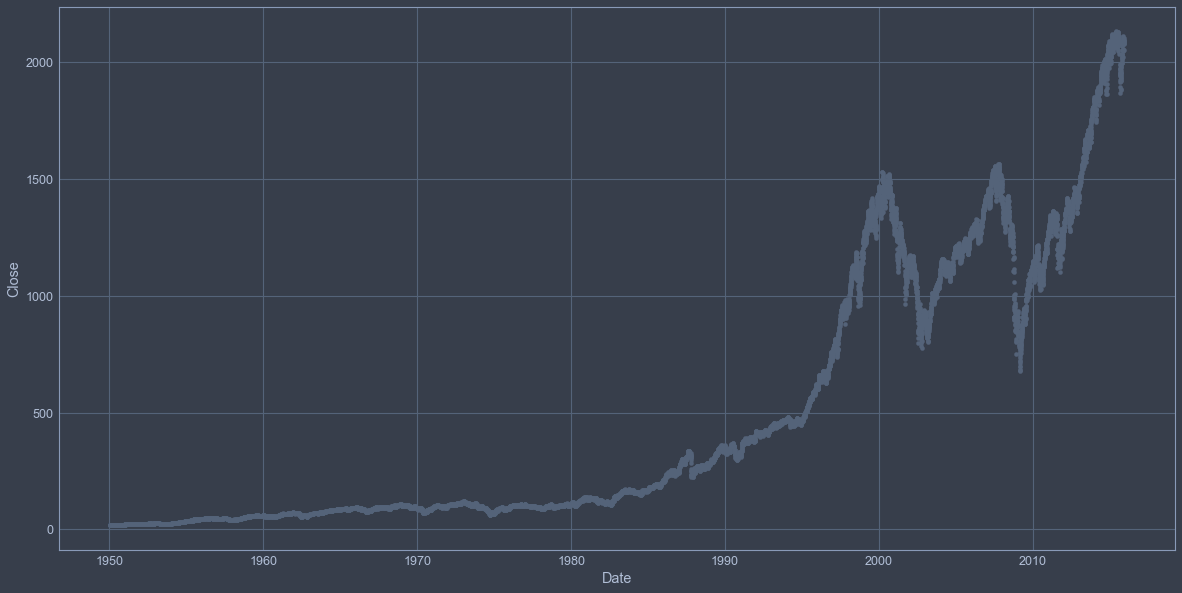

In [173]:
sphist.reset_index().plot.scatter('Date', 'Close', figsize = (20,10))
plt.show()

In [174]:
sphist.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
1950-01-03,16.66,16.66,16.66,16.66,1260000.0,16.66
1950-01-04,16.85,16.85,16.85,16.85,1890000.0,16.85
1950-01-05,16.93,16.93,16.93,16.93,2550000.0,16.93
1950-01-06,16.98,16.98,16.98,16.98,2010000.0,16.98
1950-01-09,17.08,17.08,17.08,17.08,2520000.0,17.08


Datasets taken from the stock market need to be handled differently than datasets from other sectors when it comes time to make predictions. In a normal machine learning exercise, we treat each row as independent. Stock market data is sequential, and each observation comes a day after the previous observation. Thus, the observations are not all independent, and you can't treat them as such.

This means you have to be extra careful to not inject "future" knowledge into past rows when you do training and prediction. Injecting future knowledge will make our model look good when you're training and testing it, but will make it fail in the real world. This is how many algorithmic traders lose money.

The time series nature of the data means that can generate indicators to make our model more accurate. For instance, you can create a new column that contains the average price of the last 10 trades for each row. This will incorporate information from multiple prior rows into one, and will make predictions much more accurate.

When you do this, you have to be careful not to use the current row in the values you average. You want to teach the model how to predict the current price from historical prices. If you include the current price in the prices you average, it will be equivalent to handing the answers to the model upfront, and will make it impossible to use in the "real world", where you don't know the price upfront.

Here are some indicators that are interesting to generate for each row:
- The average price from the past 5 days.
- The average price for the past 30 days.
- The average price for the past 365 days.
- The ratio between the average price for the past 5 days, and the average price for the past 365 days.
- The standard deviation of the price over the past 5 days.
- The standard deviation of the price over the past 365 days.
- The ratio between the standard deviation for the past 5 days, and the standard deviation for the past 365 days.

"Days" means "trading days" -- so if you're computing the average of the past 5 days, it should be the 5 most recent dates before the current one. Assume that "price" means the Close column. Always be careful not to include the current price in these indicators! You're predicting the next day price, so our indicators are designed to predict the current price from the previous prices.

Some of these indicators require a year of historical data to compute. Our first day of data falls on 1950-01-03, so the first day you can start computing indicators on is 1951-01-03.

To compute indicators, you'll need to loop through each day from 1951-01-03 to 2015-12-07 (the last day you have prices for). For instance, if we were computing the average price from the past 5 days, we'd start at 1951-01-03, get the prices for each day from 1950-12-26 to 1951-01-02, and find the average. The reason why we start on the 26th, and take more than 5 calendar days into account is because the stock market is shutdown on certain holidays. Since we're looking at the past 5 trading days, we need to look at more than 5 calendar days to find them.




In [175]:
sphist['mean_5'] = sphist['Close'].rolling(5).mean().shift(1)
sphist['mean_30'] = sphist['Close'].rolling(30).mean().shift(1)
sphist['mean_365'] = sphist['Close'].rolling(365).mean().shift(1)

sphist['ratio_5_365'] = sphist['mean_5'] / sphist['mean_365']

sphist['std_5'] = sphist['Close'].rolling(5).std().shift(1)
sphist['std_30'] = sphist['Close'].rolling(30).std().shift(1)
sphist['std_365'] = sphist['Close'].rolling(365).std().shift(1)

sphist['ratio_std_5_365'] = sphist['std_5'] / sphist['std_365']


first_set_cols = sphist.dropna().copy()

Creating the Train and Test dataset

In [176]:
def cv_split(df):
    train = df.loc[:'2013-01-01']
    test = df.loc['2013-01-01':]
    return train, test

Training the model

In [177]:
def train_test(features, target, df_train, df_test):
    X_train = df_train[features]
    y_train = df_train[target]
    X_test = df_test[features]
    y_test = df_test[target]

    model = LinearRegression().fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    return (mae, mse)

In [178]:
features = list(sphist.iloc[:,6:].columns)
target = 'Close'
train_test(features, target, cv_split(first_set_cols)[0], cv_split(first_set_cols)[1])

(16.216208263590108, 493.16985473047515)

Create more columns in order to increase models accuracy

In [179]:
sphist['mean_volume_5'] = sphist['Volume'].rolling(5).mean().shift(1)
sphist['mean_volume_365'] = sphist['Volume'].rolling(365).mean().shift(1)

sphist['ratio_volume_5_365'] = sphist['mean_volume_5'] / sphist['mean_volume_365']

sphist['std_volume_5'] = sphist['Volume'].rolling(5).std().shift(1)
sphist['std_volume_30'] = sphist['Volume'].rolling(30).std().shift(1)
sphist['std_volume_365'] = sphist['Volume'].rolling(365).std().shift(1)

sphist['ratio_volume_std_5_365'] = sphist['std_volume_5'] / sphist['std_volume_365']

second_set_cols = sphist.dropna().copy()

In [186]:
features_2 = list(sphist.iloc[:,6:].columns)
target = 'Close'
train_test(features_2, target, cv_split(second_set_cols)[0], cv_split(second_set_cols)[1])

(16.195241174749544, 496.34710725533125)